<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/tests/StochInterp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling using the TSM objective


In [15]:
# Standard install
# !pip install -q git+https://github.com/hsimonfroy/diffusion-field-level.git

# # Editable install
# !pip install -q -e git+https://github.com/hsimonfroy/diffusion-field-level.git#egg=fldiffus
# import site; site.main() # for Colab only
# # !pip install -q diffrax

import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, grad, vmap, tree, value_and_grad, jvp, debug
jconfig.update("jax_enable_x64", True)
print(jdevices())

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from fldiffus.stochinterp import StochInterp

%matplotlib inline
%load_ext autoreload
%autoreload 2

[cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Stochastic path to sample
$\newcommand{\cA}{\mathcal{A}}\newcommand{\cB}{\mathcal{B}}\newcommand{\cC}{\mathcal{C}}\newcommand{\cF}{\mathcal{F}}\newcommand{\cG}{\mathcal{G}}\newcommand{\cH}{\mathcal{H}}\newcommand{\cL}{\mathcal{L}}\newcommand{\cM}{\mathcal{M}}\newcommand{\cN}{\mathcal{N}}\newcommand{\cO}{\mathcal{O}}\newcommand{\cP}{\mathcal{P}}\newcommand{\cR}{\mathcal{R}}\newcommand{\cS}{\mathcal{S}}\newcommand{\cT}{\mathcal{T}}\newcommand{\cU}{\mathcal{U}}\newcommand{\cW}{\mathcal{W}}\newcommand{\cX}{\mathcal{X}}\newcommand{\cY}{\mathcal{Y}}\newcommand{\cZ}{\mathcal{Z}}\newcommand{\NN}{\mathbb{N}}\newcommand{\ZZ}{\mathbb{Z}}\newcommand{\QQ}{\mathbb{Q}}\newcommand{\RR}{\mathbb{R}}\newcommand{\CC}{\mathbb{C}}\newcommand{\KK}{\mathbb{K}}\newcommand{\SS}{\mathbb{S}}\newcommand{\eps}{\varepsilon}\newcommand{\ph}{\varphi}\newcommand{\pp}{\mathrm{p}}\newcommand{\qq}{\mathrm{q}}\newcommand{\HH}{\mathrm{H}}\newcommand{\PP}{\mathbb{P}}\newcommand{\EE}{\mathbb{E}}\newcommand{\OO}{\mathbb{O}}\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}\newcommand{\bs}{\boldsymbol}\newcommand{\dd}{\mathrm{d}}\newcommand{\dxdy}[2]{\frac{\dd #1}{\dd #2}}\newcommand{\pxpy}[2]{\frac{\partial #1}{\partial #2}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\newcommand{\norm}[1]{\left\lVert#1\right\rVert}\newcommand{\T}{^\top}\newcommand{\ind}{\perp\!\!\!\perp}\newcommand{\1}{\mathbb{1}}\newcommand{\intint}[1]{\left[\!\left[#1\right]\!\right]}\newcommand{\lat}{x}\newcommand{\Lat}{X}\newcommand{\Ls}{\mathcal X}\newcommand{\obs}{y}\newcommand{\Obs}{Y}\newcommand{\Os}{\mathcal Y}\newcommand{\obst}{z}\newcommand{\Obst}{Z}\newcommand{\Ost}{\mathcal Z}$
* Let us have a target $x_1 \sim \pp_1$ and a stochastic Gaussian interpolation $$x_t = \alpha_t x_1 + \beta_t \eps,$$ with $\eps \sim \cN(\bs 0, I)$, scaling term $\alpha_t$, noise term $\beta_t$. We typically want $\alpha_0 \approx \beta_1 \approx 0$ and $\alpha_1 \approx \beta_0 \approx 1$. Then $$x_t \sim \pp_t = \alpha_t^{-1}\pp_1(\alpha_t^{-1} \cdot) * \cN(0, \beta_t^2).$$
* Let us define drift term $f_t(x) := \frac{\dot \alpha_t}{\alpha_t}x$ and diffusion term $g_t^2 := 2( \frac{\dot \alpha_t}{\alpha_t}\beta_t^2 - \beta_t \dot \beta_t ) = - \alpha_t^2 \dot{\left(\frac{\beta_t^2}{\alpha_t^2}\right)}$
* Then, the 3 following processes $(x(t))_{t}$ admits the same marginals $\forall t, x(t) \sim x_t$:
	* ODE $\begin{cases}\exists t_0, x(t_0) \sim x_{t_0}\\ 	\dd x = v_t(x) \dd t \quad\textrm{with}\quad v_t:= f_t+\frac{g_t^2}{2}\nabla\log\pp_t\end{cases}$
	* Backward (noising) SDE $\begin{cases}x(1) \sim x_{1}\\ 	\dd x = \left(v_t-\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd \tilde W = f_t\ \dd t + g_t\ \dd \tilde W \end{cases}$  
	  with $\tilde W$ a backward Wiener process.
	* Forward (denoising) SDE $\begin{cases}x(0) \sim x_{0}\\ 	\dd x = \left(v_t+\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd W = \left(f_t+g_t^2\nabla\log\pp_t\right) \dd t + g_t\ \dd W\end{cases}$    
	  with $W$ a forward Wiener process.

* Noise scheduling:
	* Variance Preserving (VP): $\beta_t^2 = 1-\alpha_t^2$.  
	  This implies $f_t(\bs x) = \frac{\dot \alpha_t}{\alpha_t}\bs x = \frac{g_t^2}{2}\bs x$. Typically $g_t^2 = t g_\mathrm{min}^2 + (1-t) g_\mathrm{max}^2$, then $\alpha_t = \exp\left(({g_\mathrm{min}^2(t^2-1) - g_\mathrm{max}^2(1-t)^2)/4}\right)$.
	* Variance Exploding (VE): $\alpha_t = 1$.  
	  This implies $f_t(\bs x) = 0$ and $g_t^2 = -\dot{\beta_t^2} = -2\beta_t \dot \beta_t$. Typically $\beta_t = \beta_\mathrm{min}^t \beta_\mathrm{max}^{1-t}$, then $g_t^2 = 2\beta_t^2 \log\left(\frac{\beta_\mathrm{max}}{\beta_\mathrm{min}}\right)$.
	*  Optimal Transport (OT): $\alpha_t = t = 1 - \beta_t$.  
	  This implies $f_t(\bs x) = \frac{\bs x}{t}$, $g_t^2 = 2\left(\frac{1}{t} - 1\right)$.
	* Pinned Brownian (PB): $\beta^2 = 4\beta_\mathrm{max}^2\alpha_t(1-\alpha_t)$.  
	  This implies $g_t^2 =  4\beta_\mathrm{max}^2 \dot \alpha_t$. Typically  $\alpha_t = t$, then $f_t(\bs x) = \frac{\bs x}{t}$, $g_t = 2\beta_\mathrm{max}$.

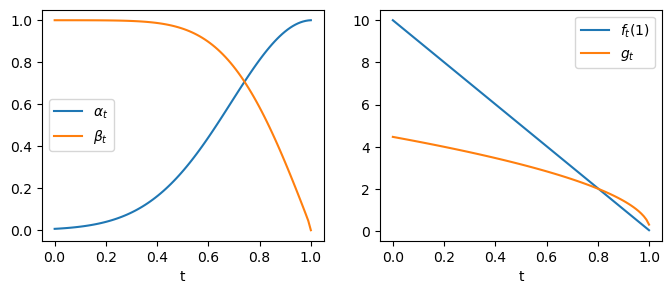

In [16]:
# @title Defining noise scheduling
stoc = StochInterp(scheduling='VP', dim=2, hutch_div=None, snapshots=100, pid=False)

tlin = jnp.linspace(0,1,100)
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(tlin, stoc.alpha(tlin), label="$\\alpha_t$")
plt.plot(tlin, stoc.beta(tlin), label="$\\beta_t$")
plt.xlabel("t"), plt.legend();

plt.subplot(122)
plt.plot(tlin, vmap(stoc.drift)(tlin, jnp.ones_like(tlin), None), label="$f_t(1)$")
plt.plot(tlin, vmap(stoc.diffusion)(tlin, jnp.ones_like(tlin), None), label="$g_t$")
plt.xlabel("t"), plt.legend();

In [17]:
n_samples = 10_000
base_samples = stoc.base.sample(n_samples, jr.key(0))
target_samples = stoc.target.sample(n_samples, jr.key(1))

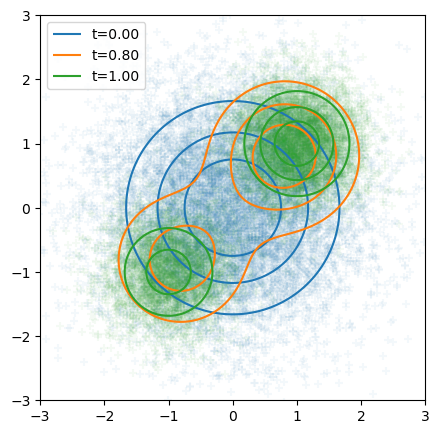

In [18]:
# @title Plot path
if stoc.dim == 1:
    plt.figure(figsize=(12,4.5))
    plt.subplot(1,2,1)
    tlin = jnp.linspace(0, 1, 7)[::-1]
    for t in tlin:
        stoc.plot_pdf(stoc.marg(t).log_prob, label=f't={t:.2f}')

    stoc.plot_pdf(tfd.Normal(loc=0., scale=1.).log_prob, ':k', label='standard');
    stoc.plot_samples(base_samples, label='base', color=f'C{len(tlin)-1}');
    stoc.plot_samples(target_samples, label='target', color='C0');
    plt.legend()

    plt.subplot(1,2,2)
    stoc.plot_margs()
    
elif stoc.dim == 2:
    plt.figure(figsize=(5,5))
    tlin = jnp.array([0., 0.8, 1.])
    handles = []
    labels = []

    for it, t in enumerate(tlin):
        quad = stoc.plot_pdf(stoc.marg(t).log_prob, levels=3, colors=f'C{it}')
        handles.append(quad.legend_elements()[0][0])
        labels.append(f't={t:.2f}')

    stoc.plot_samples(base_samples, label='base', color=f'C0');
    stoc.plot_samples(target_samples, label='target', color=f'C{len(tlin)-1}');
    plt.legend(handles, labels);

Let's try to verify that our integration time is going to be good enough, by running backward and forward ODEs and SDEs. We should obtain base distribution for the backward ones, and the target distribution for the forward ones.

In [19]:
params = None # target
# params = stoc.params
seeds = jr.split(jr.key(0), n_samples)
ts_bsde, xs_bsde = stoc.backward_sde(seeds, target_samples)
ts_fsde, xs_fsde = stoc.forward_sde(params, seeds, base_samples)
ts_bode, xs_bode, _ = stoc.backward_ode(params, target_samples)
ts_fode, xs_fode, _ = stoc.forward_ode(params, base_samples)

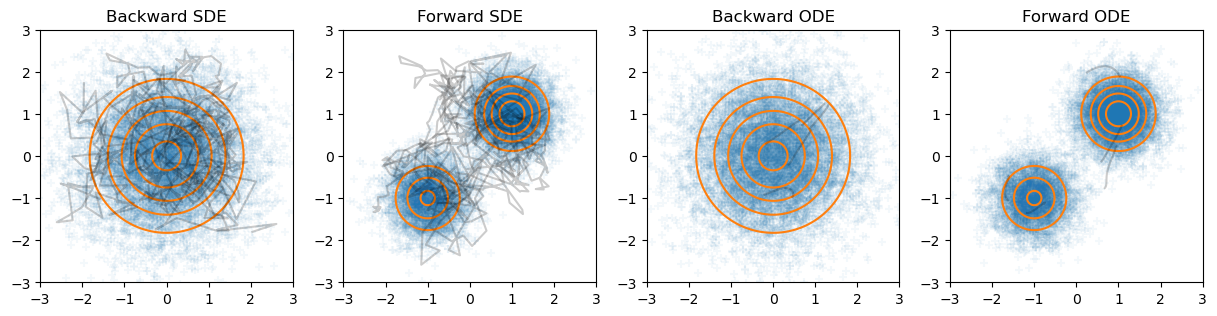

In [20]:
# @title Let's take a look at the trajectories
if stoc.dim == 1:
    n_traj = 100
    plt.figure(figsize=(14,6))
    plt.subplot(241)
    plt.plot(ts_bsde[:n_traj].T, xs_bsde[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward SDE')

    plt.subplot(242)
    plt.plot(ts_fsde[:n_traj].T, xs_fsde[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward SDE')

    plt.subplot(243)
    plt.plot(ts_bode[:n_traj].T, xs_bode[:n_traj,:,0].T, 'k', alpha=0.1);    
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward ODE')

    plt.subplot(244)
    plt.plot(ts_fode[:n_traj].T, xs_fode[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward ODE');

    plt.subplot(245)
    stoc.plot_pdf(stoc.base.log_prob)
    stoc.plot_samples(xs_bsde[:,-1])

    plt.subplot(246)
    stoc.plot_pdf(stoc.target.log_prob)
    stoc.plot_samples(xs_fsde[:,-1])

    plt.subplot(247)
    stoc.plot_pdf(stoc.base.log_prob)
    stoc.plot_samples(xs_bode[:,-1])

    plt.subplot(248)
    stoc.plot_pdf(stoc.target.log_prob)
    stoc.plot_samples(xs_fode[:,-1])

elif stoc.dim == 2:
    n_traj = 5
    levels = 5
    plt.figure(figsize=(15,5))
    plt.subplot(141)
    stoc.plot_pdf(stoc.base.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_bsde[:,-1], color='C0')
    plt.plot(*xs_bsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward SDE')

    plt.subplot(142)
    stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_fsde[:,-1], color='C0')
    plt.plot(*xs_fsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward SDE')

    plt.subplot(143)
    stoc.plot_pdf(stoc.base.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_bode[:,-1], color='C0')
    plt.plot(*xs_bode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward ODE');

    plt.subplot(144)
    stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_fode[:,-1], color='C0')
    plt.plot(*xs_fode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward ODE');

## 2 Score network and associated proposal probability
* Eulerian formulation: the continuity equation yields $\partial_t \pp_t = -\nabla \cdot (\pp_t v_t),$ i.e.
$$\partial_t \log \pp_t = -\nabla \cdot v_t - \nabla \log \pp_t \cdot v_t.$$

* Lagrangian formulation: the continuous change of variable formula along a particle trajectory yields $\dd \log \pp_t(x(t)) = - \nabla \cdot v_t(x(t)) \ \dd t$, hence$$\log \pp_\tau(x(\tau)) = \log \pp_0(x(0)) - \int^\tau_0 \nabla \cdot v_t(x(t))\dd t = \log \pp_0(x(0)) + \int_\tau^0 \nabla \cdot v_t(x(t))\dd t$$For ODE sampling, we can simultaneously integrate forward the probability flow starting at $x(0)$, whereas for the SDE sampling, we must integrate the probability flow backward from $x(1)$ since we do not know $x(0)$.

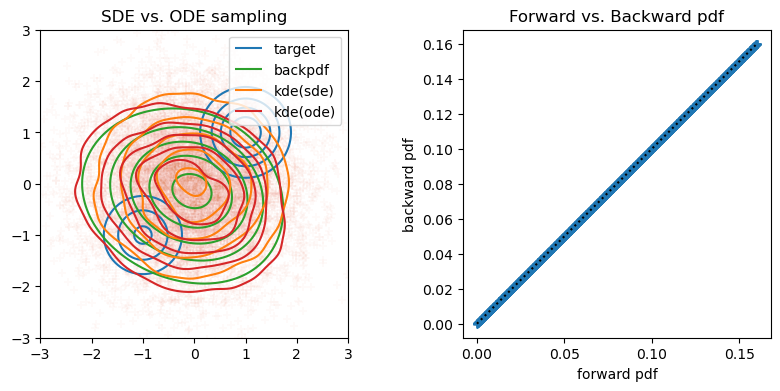

In [21]:
# @title Plot path
params = stoc.params
# params = None # target
n_samples = 10_000

def plot_results(params):
    seeds = jr.split(jr.key(0), n_samples)
    x1_sde = stoc.sample_sde(params, seeds)
    x1_ode, logp1f = stoc.sample_ode(params, seeds)
    logp1b = stoc.backward_logpdf(params, x1_ode)

    if stoc.dim == 1:
        stoc.plot_pdf(stoc.target.log_prob, 'C0', label='target')
        stoc.plot_pdf(partial(stoc._backward_logpdf, params), 'C2', label='backpdf')
        stoc.plot_kde(x1_sde, 'C1', label='kde(sde)')
        stoc.plot_kde(x1_ode, 'C3', label='kde(ode)')
        stoc.plot_samples(x1_sde, color='C1', alpha=0.1)
        stoc.plot_samples(x1_ode, color='C3', alpha=0.1)
        plt.legend()
        plt.title('SDE vs. ODE sampling')

    elif stoc.dim == 2:
        levels = 5
        handles = []
        labels = ['target', 'backpdf', 'kde(sde)', 'kde(ode)']

        quad = stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C0')
        handles.append(quad.legend_elements()[0][0])
        quad = stoc.plot_pdf(partial(stoc._backward_logpdf, params), levels=levels, colors='C2')
        handles.append(quad.legend_elements()[0][0])
        stoc.plot_samples(x1_sde, color='C1', alpha=0.01)
        quad = stoc.plot_kde(x1_sde, levels=levels, colors='C1')
        handles.append(quad.legend_elements()[0][0])
        stoc.plot_samples(x1_sde, color='C3', alpha=0.01)
        quad = stoc.plot_kde(x1_ode, levels=levels, colors='C3')
        handles.append(quad.legend_elements()[0][0])
        plt.legend(handles, labels)
        plt.title('SDE vs. ODE sampling')
    return x1_sde, x1_ode, logp1f, logp1b

plt.figure(figsize=(10,4))
plt.subplot(121)
x1_sde, x1_ode, logp1f, logp1b = plot_results(params)

plt.subplot(122)
p1f, p2f = jnp.exp(logp1f), jnp.exp(logp1b)
plt.plot(p1f, p2f, '+', alpha=0.5);
minmax = [min(p1f.min(), p2f.min()), max(p1f.max(), p2f.max())]
plt.plot(minmax, minmax, ':k')
plt.gca().set_aspect(1.)
plt.xlabel('forward pdf'), plt.ylabel('backward pdf');
plt.title('Forward vs. Backward pdf');

## 3 Loss and training
* Most of the approches rely on estimating $v_t$ or $\nabla\log \pp_t$ via the identities:
	* $v_t(x_t) = \int v_{t \mid 1}(x_t \mid x_1)\ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{t\mid 1}(x_t \mid x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \alpha_t^{-1} \nabla \log \pp_{1}(x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$    for additive noise
* Let us define the following losses:
	* $\cL_\mathrm{FM}(\theta) := \EE_{t, x_t}[\norm{v_t^{\theta}(x_t) - v_t(x_t)}^2]$
	* $\cL_\mathrm{DFM}(\theta) := \EE_{t, x_1, x_t}[\norm{v_t^{\theta}(x_t) - v_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{SM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t}(x_t)}^2]$
	* $\cL_\mathrm{ISM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) }^2 + 2\nabla \cdot s^{\theta}_t(x_t) ]$
	* $\cL_\mathrm{DSM}(\theta) := \EE_{t, x_1, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TSM}(\theta) := \EE_{t, x_1, x_t}[\norm{s^{\theta}_t(x_t) - \alpha_t^{-1} \nabla\log \pp_{1}(x_1)}^2]$    for additive noise [*source*](http://arxiv.org/abs/2402.08667)
	* $\cL_\mathrm{EM}(\theta) := \EE_{t, x_1, x_t}[\norm{u^{\theta}_t(x_t) +\log \pp_{t}(x_t)}^2]$    [*source*](https://arxiv.org/pdf/2409.09787)
* Then we have
	* $\nabla_\theta \cL_\mathrm{FM} = \nabla_\theta \cL_\mathrm{DFM}$ and their argmin on $v^\theta$ is $v$.
	* $\nabla_\theta \cL_\mathrm{SM}= \nabla_\theta \cL_\mathrm{ISM} = \nabla_\theta \cL_\mathrm{DSM} = \nabla_\theta \cL_\mathrm{TSM}$ and their argmin on $s^\theta$ is $\nabla\log \pp$.

* The previous losses are on-policy, meaning they assume we can sample from target $x_1$. In the literature, there are two main ways of performing off-policy sampling (no target samples available) with diffusion/flow model. First define a regression objective $s_t(\bs y_1,\bs y_t) = \lambda_t \nabla\log\pp_1(\bs y_1) + (1-\lambda_t)\nabla\log \pp_{t\mid 1}(\bs y_t \mid \bs y_1)$ (mixture TSM+DSM). Then one can perform Importance Sampling (IS)
	* in the loss$$\cL({\bs \theta}) := \EE_{t, \bs y_1, \bs y_t}[w(\bs y_1) \norm{s^{{\bs \theta}}_t(\bs y_t) - s_t(\bs y_1,\bs y_t)}^2],$$
	* in the regression objective $$\cL({\bs \theta}) := \EE_{t, \bs y_1, \bs y_t}[\norm{s_t^{{\bs \theta}}(\bs y_t) - \EE_{\bs z_1\mid \bs y_t}[w(\bs z_1)s_t(\bs z_1,\bs z_t)]}^2],$$
  where $y_1$ is a proposal variable for $x_1$, and $y_t := \alpha_t y_1 + \beta_t \eps$.



In [49]:
# Training loop
stoc = StochInterp(scheduling='VP', dim=2, hutch_div=None, snapshots=None, pid=False)
params = stoc.params

batch_size = 2**13 # 2**16
seed = jr.key(0)

losses = []
eval_per_esss = []
off_policy = False
score_identity = False

# Define the optimizer
import optax
# optimizer = optax.chain(
#     optax.adam(learning_rate=1e-2),
#     optax.contrib.reduce_on_plateau(factor=2**.5, patience=10,),
#     )
# lr_schedule = optax.schedules.linear_onecycle_schedule(transition_steps=100, peak_value=1e-2,)
# # optimizer = optax.adam(learning_rate=lr_schedule)

optimizer = optax.adam(learning_rate=1e-2) # 1e-3
opt_state = optimizer.init(params)

In [50]:
# @title Define the score matching and score identity losses
def importance_weighting(logp1, logprop, clip=0.99, self_normalize=False):
    imp_weight = logp1 - logprop # (batch_size,)
    
    # Clip too large weights
    imp_weight = jnp.clip(imp_weight, a_max=jnp.quantile(imp_weight, clip))
    # imp_weight = jnp.clip(imp_weight, max=jnp.quantile(imp_weight, clip))

    if self_normalize:
        imp_weight = jnp.exp(imp_weight - imp_weight.max(0))
        imp_weight = (imp_weight / imp_weight.mean(0))[...,None] # (imp_size, 1)
    else:
        imp_weight = jnp.exp(imp_weight)[...,None]
    return imp_weight

def loss_sm(params, t, x1, z, score1, imp_weight):
    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)

    xt = alphat * x1 + betat * z
    score_est = vmap(partial(stoc.scorenn.apply, params))(t, xt)

    score_tsm = score1 / alphat
    score_dsm = - z / betat

    error_tsm = (alphat * (score_est - score_tsm))**2
    error_dsm = (betat * (score_est - score_dsm))**2
    # gt = vmap(stoc.diffusion)(t, jnp.ones_like(t)[:,None], None)
    # error_dsm = (gt * (score_est - score_dsm))**2 # MLE time weighting, see http://arxiv.org/abs/2101.09258

    # error_tdsm = error_dsm + error_tsm
    score_tdsm = (alphat**2 * score_tsm + betat**2 * score_dsm) / (alphat**2 + betat**2)
    error_tdsm = (alphat**2 + betat**2) * (score_est - score_tdsm)**2

    # return (error_tdsm * imp_weight).mean()
    # return (error_dsm * imp_weight).mean()
    return (error_tsm * imp_weight).mean()

from jax.scipy.special import logsumexp
def loss_si(params, t, x1, z, seed_si):
    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)
    xt = alphat * x1 + betat * z # (batch_size, dim)
    score_est = vmap(partial(stoc.scorenn.apply, params))(t, xt)

    def score_si(seed, xt, alphat, betat):
        imp_size = 2**13
        z1prop = jr.normal(seed, (imp_size, xt.shape[-1]))
        x1prop = z1prop * betat + xt # (imp_size, dim)

        logp1prop = vmap(lambda x: stoc.target.log_prob(x / alphat))(x1prop) # (imp_size,)
        imp_weight = importance_weighting(logp1prop, jnp.zeros_like(logp1prop), clip=1., self_normalize=True)
        score_dsi = (z1prop * imp_weight).mean(0) / betat

        # score_tsi = (vmap(grad(lambda x: stoc.target.log_prob(x / alphat)))(x1prop) * imp_weight).mean(0)
        lse = lambda x: logsumexp(vmap(lambda zz: stoc.target.log_prob((zz * betat + x) / alphat))(z1prop), axis=0)
        score_tsi = grad(lse)(xt) # More stable

        # Clip too large scores
        score_tsi = jnp.clip(score_tsi, a_max=jnp.quantile(score_tsi, 0.99))
        score_dsi = jnp.clip(score_dsi, a_max=jnp.quantile(score_dsi, 0.99))
        # score_tsi = jnp.clip(score_tsi, max=jnp.quantile(score_tsi, 0.99))
        # score_dsi = jnp.clip(score_dsi, max=jnp.quantile(score_dsi, 0.99))
        return score_tsi, score_dsi

    score_tsi, score_dsi = vmap(score_si)(jr.split(seed_si, x1.shape[0]), xt, alphat, betat)
    error_tsi = (alphat * (score_est - score_tsi))**2
    error_dsi = (betat * (score_est - score_dsi))**2
    
    # error_tdsi = error_tsi + error_dsi
    score_tdsi = (alphat**2 * score_tsi + betat**2 * score_dsi) / (alphat**2 + betat**2)
    error_tdsi = (alphat**2 + betat**2) * (score_est - score_tdsi)**2

    return error_tdsi.mean()
    # return error_tsi.mean()
    # return error_dsi.mean()


# Define the training step
@jit
def train_step(params, opt_state, seed):
    # Sample true x1 or proposal x1
    seed_samp, seed_time, seed_noise, seed_si = jr.split(seed, 4)
    if off_policy:
        # # Current SDE proposal
        # x1 = stoc.sample_sde(params, jr.split(seed_samp, batch_size)) # (batch_size, dim)
        # logprop = stoc.backward_logpdf(params, x1)

        # Current ODE proposal
        x1, logprop = stoc.sample_ode(params, jr.split(seed_samp, batch_size))

        # # Base proposal
        # x1 = stoc.base.sample(batch_size, seed_samp)
        # logprop = vmap(stoc.base.log_prob)(x1)
        
        logp1, score1 = vmap(value_and_grad(stoc.target.log_prob))(x1)
        imp_weight = importance_weighting(logp1, logprop, clip=0.99, self_normalize=True)
    else:
        # Sample from target directly
        x1 = stoc.target.sample(batch_size, seed_samp) # (batch_size, dim)
        score1 = vmap(stoc.score_target)(x1)
        imp_weight = jnp.ones((batch_size, 1))

    # For importance weights such that E[W]=1, we have n/ESS = E[W^2] = Var[W] + 1
    eval_per_ess = (imp_weight**2).mean()

    # Sample t and xt
    t = jr.uniform(seed_time, (batch_size,), minval=stoc.eps, maxval=1-stoc.eps)
    z = jr.normal(seed_noise, jnp.shape(x1))

    if score_identity:
        loss, grads = value_and_grad(loss_si)(params, t, x1, z, seed_si)
    else:
        loss, grads = value_and_grad(loss_sm)(params, t, x1, z, score1, imp_weight)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, (loss, eval_per_ess)

Epoch 0, Loss: 3.67525, n/ESS: 1.00000
Epoch 10, Loss: 3.44641, n/ESS: 1.00000
Epoch 20, Loss: 3.30387, n/ESS: 1.00000
Epoch 30, Loss: 3.26597, n/ESS: 1.00000
Epoch 40, Loss: 3.32634, n/ESS: 1.00000
Epoch 50, Loss: 3.29224, n/ESS: 1.00000
Epoch 60, Loss: 3.21346, n/ESS: 1.00000
Epoch 70, Loss: 3.30587, n/ESS: 1.00000
Epoch 80, Loss: 3.20965, n/ESS: 1.00000
Epoch 90, Loss: 3.29973, n/ESS: 1.00000
Epoch 100, Loss: 3.31284, n/ESS: 1.00000
Epoch 110, Loss: 3.19906, n/ESS: 1.00000
Epoch 120, Loss: 3.24494, n/ESS: 1.00000
Epoch 130, Loss: 3.27782, n/ESS: 1.00000
Epoch 140, Loss: 3.29415, n/ESS: 1.00000
Epoch 150, Loss: 3.22243, n/ESS: 1.00000
Epoch 160, Loss: 3.28709, n/ESS: 1.00000
Epoch 170, Loss: 3.25295, n/ESS: 1.00000
Epoch 180, Loss: 3.28070, n/ESS: 1.00000
Epoch 190, Loss: 3.29307, n/ESS: 1.00000
Epoch 200, Loss: 3.26471, n/ESS: 1.00000
Epoch 210, Loss: 3.31771, n/ESS: 1.00000
Epoch 220, Loss: 3.25370, n/ESS: 1.00000
Epoch 230, Loss: 3.30353, n/ESS: 1.00000
Epoch 240, Loss: 3.30164, n

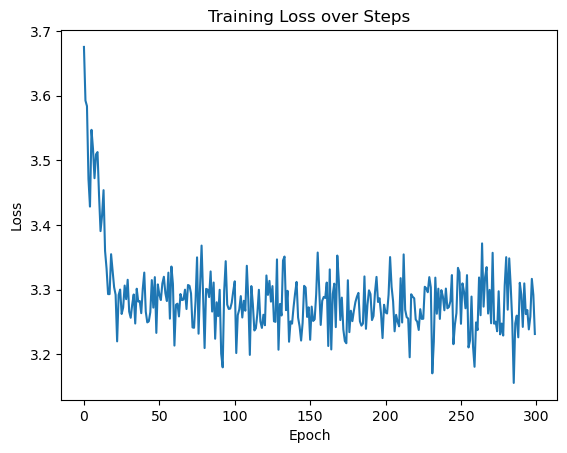

In [ ]:
for epoch in range(200):
    seed, seed_train = jr.split(seed, 2)
    params, opt_state, (loss, eval_per_ess) = train_step(params, opt_state, seed)
    losses.append(loss)
    eval_per_esss.append(eval_per_ess)

    if epoch % 10 == 0:
        # print(f"Epoch {epoch}, Loss: {loss}, lr scale: {optax.tree.get(optim_state, 'scale')}")
        # print(f"Epoch {epoch}, Loss: {loss:.5f}, n/ESS: {eval_per_ess:.5f}, lr scale: {opt_state[1].scale}")
        print(f"Epoch {epoch}, Loss: {loss:.5f}, n/ESS: {eval_per_ess:.5f}")

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

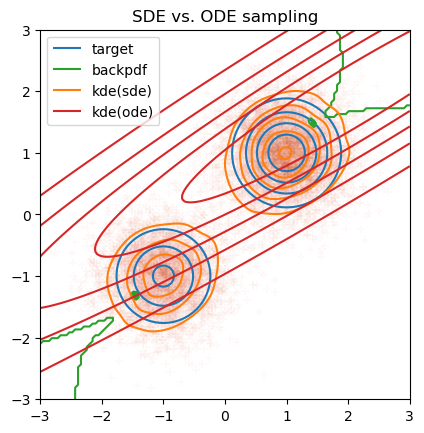

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # OT TDSI on

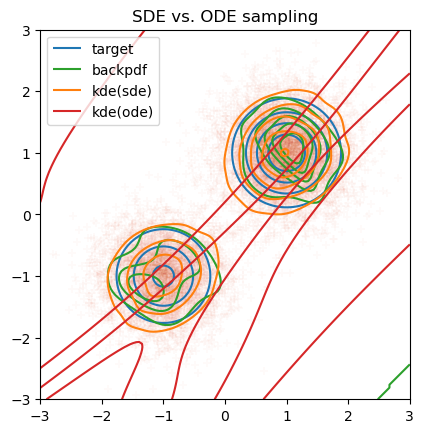

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # OT DSI on

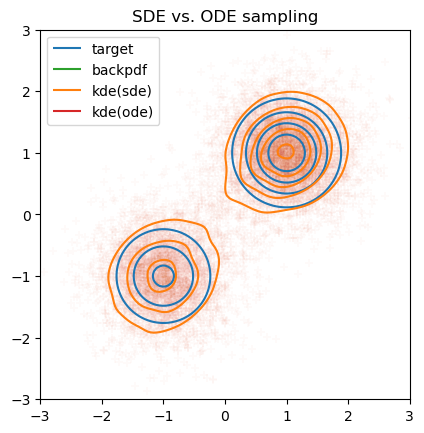

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # PB TDSI on

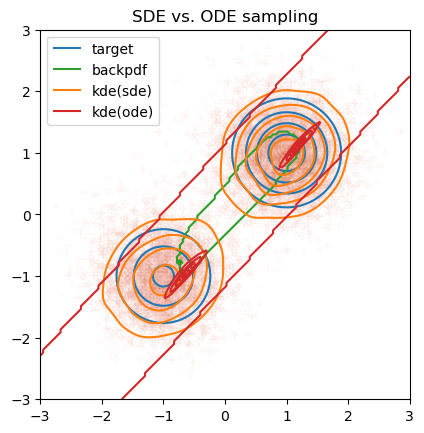

In [38]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TSI on

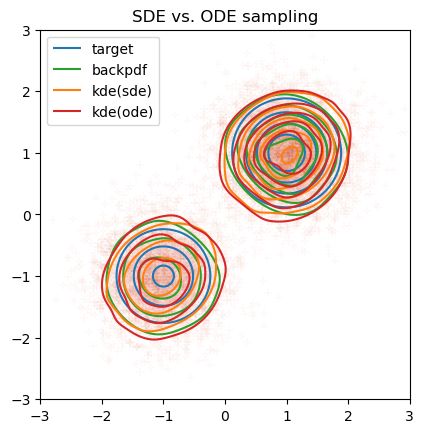

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TDSI on

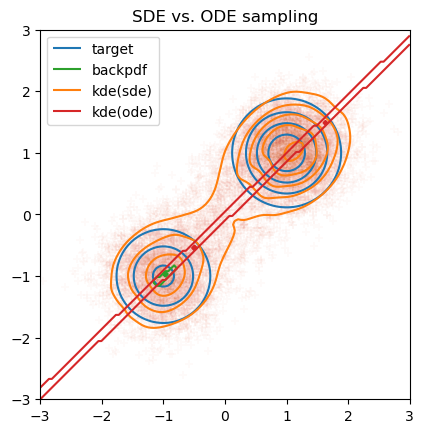

In [46]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TSI off

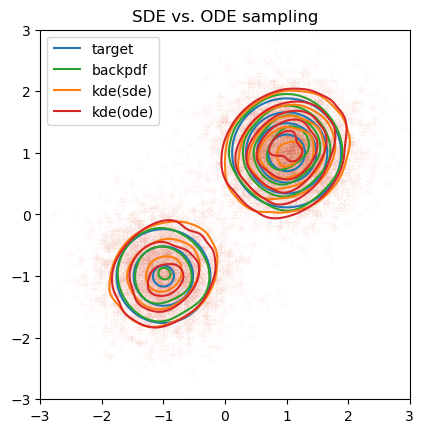

In [17]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSI off

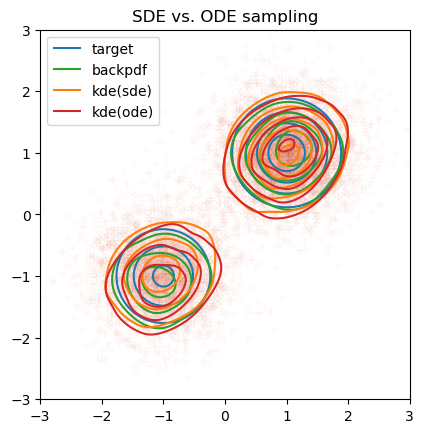

In [14]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TSI+DSI off

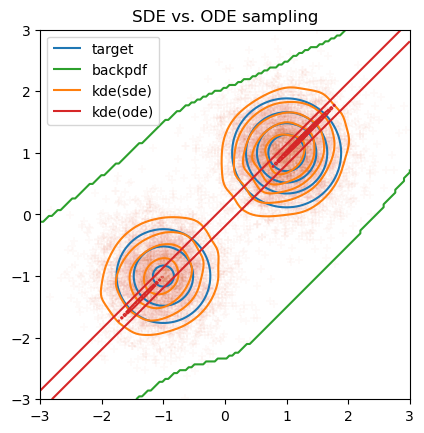

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TSM on

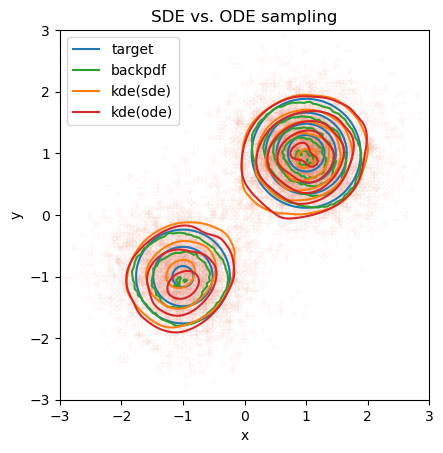

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSM on

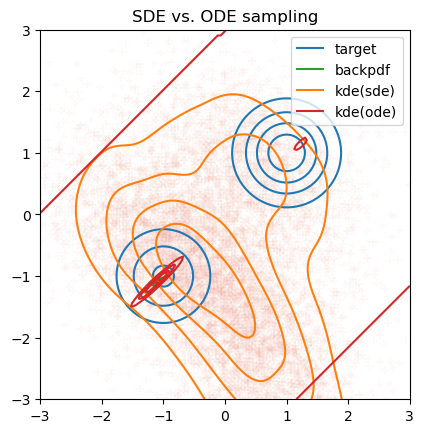

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TSM off

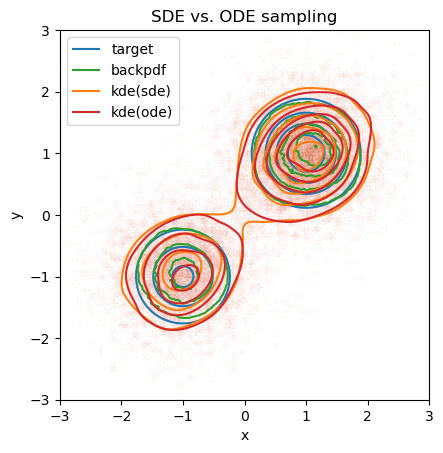

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSM off

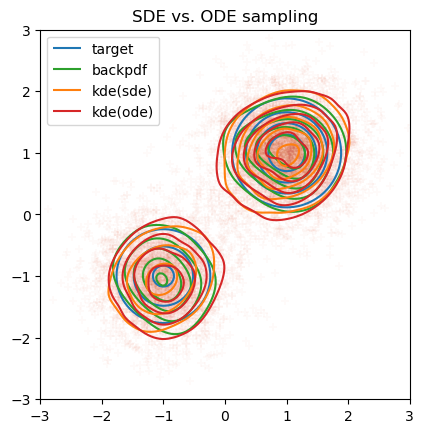

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TDSM off

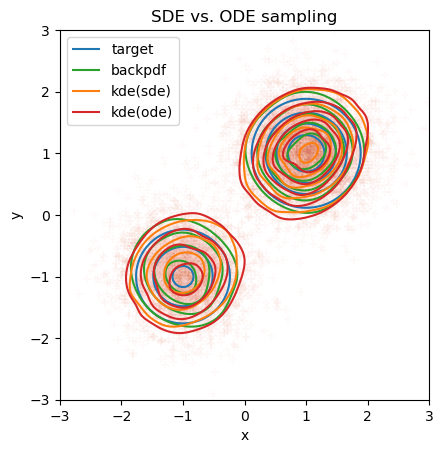

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TDSM off, unormalized IS

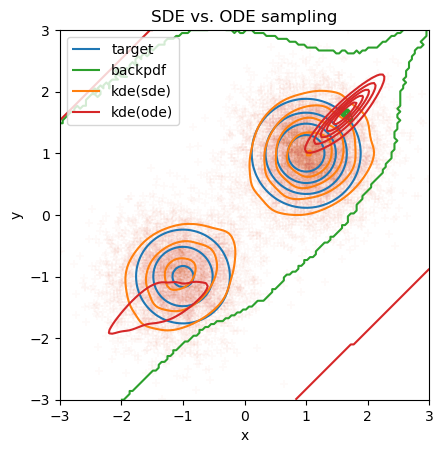

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # OT DSM on

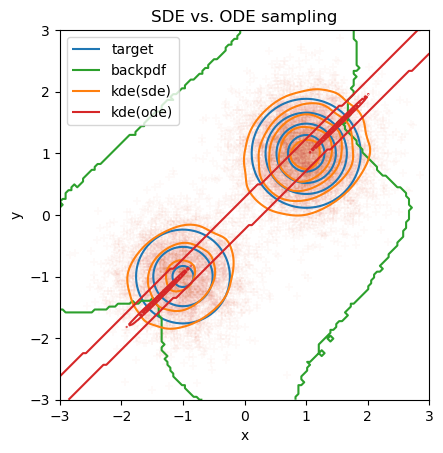

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # OT TDSM on

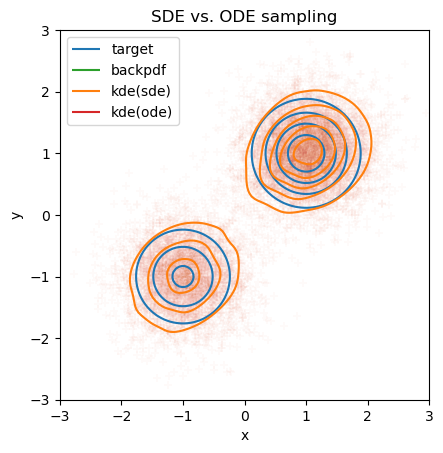

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # PB TDSM on

## 4. Scaling of Importance Sampling
Where we look at the variances of objectives and losses and their dependency to dimension and sample size.
* Recall the regression objective $s_t(y_1,y_t) = \lambda_t \nabla\log\pp_1(x_1) + (1-\lambda_t)\nabla\log \pp_{t\mid 1}(y_t \mid y_1)$ (mixture TSM+DSM). We want to look at $$\EE_{t, \bs y_1, \bs y_t}[w(\bs y_1)\norm{\nabla \log \pp_t(\bs y_t) - s_t(\bs y_1,\bs y_t)}^2] = \Var_{t, \bs x_1, \bs x_t}[s_t(\bs x_1,\bs x_t)]$$ and $$\Var_{t, \bs y_1, \bs y_t}[w(\bs y_1)\norm{\nabla \log \pp_t(\bs y_t) - s_t(\bs y_1,\bs y_t)}^2]$$

### Scaling with dimension

In [ ]:
@partial(jit, static_argnames=['dim', 'batch_size', 'off_policy'])
def loss_sm(seed, batch_size, dim, off_policy=True):
    stoc = StochInterp(scheduling='VP', dim=dim, hutch_div=None, snapshots=None, pid=False)
    seed_samp, seed_time, seed_noise = jr.split(seed, 3)

    if off_policy:
        # Base proposal
        x1 = stoc.base.sample(batch_size, seed_samp)
        logprop = vmap(stoc.base.log_prob)(x1)
        
        logp1, score1 = vmap(value_and_grad(stoc.target.log_prob))(x1)
        # logp1, score1 = vmap(value_and_grad(tfd.MultivariateNormalDiag(loc=jnp.zeros(dim), scale_diag=0.9*jnp.ones(dim)).log_prob))(x1)
        imp_weight = logp1 - logprop # (batch_size,)
        
        # imp_weight = jnp.clip(imp_weight, a_max=jnp.quantile(imp_weight, 0.999)) # Clip too large weights
        # imp_weight = jnp.clip(imp_weight, max=jnp.quantile(imp_weight, 0.999)) # Clip too large weights
        imp_weight = jnp.exp(imp_weight - imp_weight.max())
        imp_weight = (imp_weight / imp_weight.mean())[:,None] # (batch_size, 1)
    else:
        x1 = stoc.target.sample(batch_size, seed_samp) # (batch_size, dim)
        score1 = vmap(stoc.score_target)(x1)
        imp_weight = jnp.ones((batch_size, 1))

    t = jr.uniform(seed_time, (batch_size,), minval=stoc.eps, maxval=1-stoc.eps)
    z = jr.normal(seed_noise, jnp.shape(x1))

    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)

    xt = alphat * x1 + betat * z
    score_marg = vmap(stoc.score_marg)(t, xt)
    # score_marg = - xt / (0.9**2 * alphat**2 + betat**2)

    error_dsm = (score_marg * betat + z)**2
    error_tsm = (score_marg * alphat - score1)**2
    error_dsm *= imp_weight
    error_tsm *= imp_weight
    eval_per_ess = (imp_weight**2).mean()

    dsm_mean, dsm_std = error_dsm.mean(), error_dsm.mean(-1).std()
    tsm_mean, tsm_std = error_tsm.mean(), error_tsm.mean(-1).std()
    return dsm_mean, dsm_std, tsm_mean, tsm_std, eval_per_ess


dsm_means = []
dsm_stds = []
tsm_means = []
tsm_stds = []
eval_per_esss = []
dims = np.logspace(0, 3, 10, dtype=int)
batch_size = 2**18
seed = jr.key(0)
off_policy = True

for dim in dims:
    print(f"Dim {dim}")
    seed, seed_loss = jr.split(seed, 2)
    dsm_mean, dsm_std, tsm_mean, tsm_std, eval_per_ess = loss_sm(seed_loss, batch_size, dim, off_policy=off_policy)
    dsm_means.append(dsm_mean)
    dsm_stds.append(dsm_std)
    tsm_means.append(tsm_mean)
    tsm_stds.append(tsm_std)
    eval_per_esss.append(eval_per_ess)

Dim 1
Dim 2
Dim 4
Dim 10
Dim 21
Dim 46
Dim 100
Dim 215
Dim 464
Dim 1000


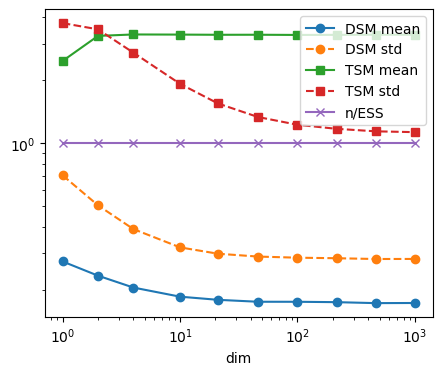

In [ ]:
plt.figure(figsize=(5,4)) # on-policy
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

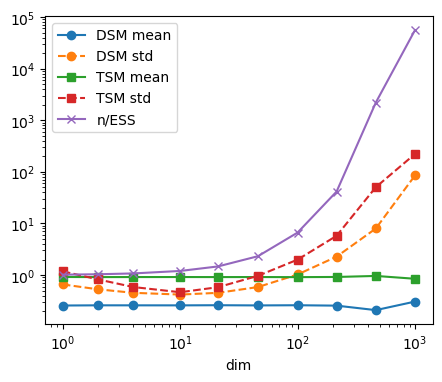

In [16]:
plt.figure(figsize=(5,4)) # off-policy Gaussian, no weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

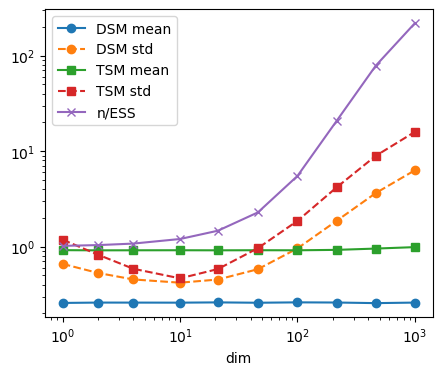

In [12]:
plt.figure(figsize=(5,4)) # off-policy Gaussian, weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

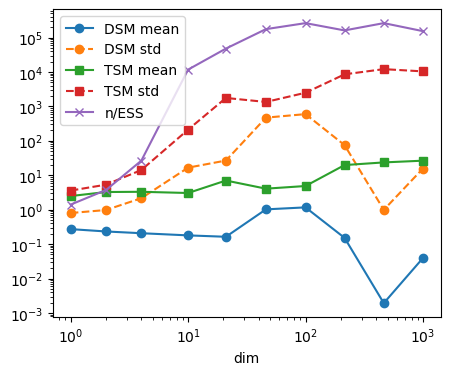

In [10]:
plt.figure(figsize=(5,4)) # off-policy, no weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

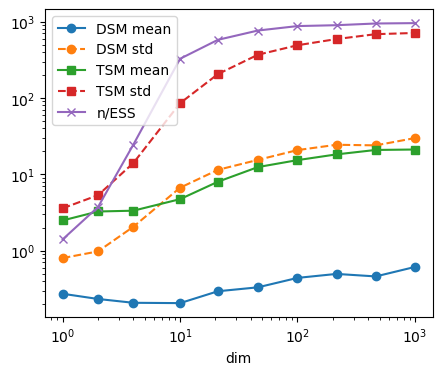

In [12]:
plt.figure(figsize=(5,4)) # off-policy, weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

### Scaling with sample size

In [ ]:
from jax.scipy.special import logsumexp
@partial(jit, static_argnames=['imp_size'])
def loss_si(seed, tmin, imp_size):
    seed_samp, seed_time, seed_noise, seed_si = jr.split(seed, 4)
    x1 = stoc.base.sample(batch_size, seed_samp)
    t = jr.uniform(seed_time, (batch_size,), minval=tmin, maxval=1-stoc.eps)
    z = jr.normal(seed_noise, jnp.shape(x1))

    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)
    xt = alphat * x1 + betat * z # (batch_size, dim)

    def score_si(seed, xt, alphat, betat):
        z1prop = jr.normal(seed, (imp_size, xt.shape[-1]))
        x1prop = z1prop * betat + xt # (imp_size, dim)

        ##### Denoising Score Identity #####
        logp1prop = vmap(lambda x: stoc.target.log_prob(x / alphat))(x1prop) # (imp_size,)
        imp_weight = importance_weighting(logp1prop, jnp.zeros_like(logp1prop), clip=1., self_normalize=True)
        score_dsi = (z1prop * imp_weight).mean(0) / betat

        ##### Target Score Identity #####
        lse = lambda x: logsumexp(vmap(lambda zz: stoc.target.log_prob((zz * betat + x) / alphat))(z1prop), axis=0)
        score_tsi = grad(lse)(xt)
        # score_tsi = (vmap(grad(lambda x: stoc.target.log_prob(x / alphat)))(x1prop) * imp_weight).mean(0)

        # score_tsi = jnp.clip(score_tsi, a_max=jnp.quantile(score_tsi, 0.99)) # Clip too large scores
        # score_dsi = jnp.clip(score_dsi, a_max=jnp.quantile(score_dsi, 0.99)) # Clip too large scores
        # score_tsi = jnp.clip(score_tsi, max=jnp.quantile(score_tsi, 0.99)) # Clip too large scores
        # score_dsi = jnp.clip(score_dsi, max=jnp.quantile(score_dsi, 0.99)) # Clip too large scores
        return score_tsi, score_dsi

    score_tsi, score_dsi = vmap(score_si)(jr.split(seed_si, x1.shape[0]), xt, alphat, betat)

    score_marg = vmap(stoc.score_marg)(t, xt)
    error_tsi = (score_marg - score_tsi)**2
    error_dsi = (score_marg - score_dsi)**2
    # error_tdsi = alphat**2 * error_tsi + betat**2 * error_dsi
    score_tdsi = alphat**2 * score_tsi + betat**2 * score_dsi # For VP
    error_tdsi = (score_marg - score_tdsi)**2
    return error_tsi.mean(), error_dsi.mean(), error_tdsi.mean()


batch_size = 2**13
seed = jr.key(0)
tmin = 0.9
imp_sizes = np.logspace(4, 15, 10, base=2, dtype=int)
errors_tsi = []
errors_dsi = []
errors_tsi2 = []
errors_dsi2 = []
errors_comb = []
errors_comb2 = []

for imp_size in imp_sizes:
    print(f'Imp size: {imp_size}')
    error_tsi, error_dsi, error_comb = loss_si(seed, tmin=tmin, imp_size=imp_size)
    errors_tsi.append(error_tsi)
    errors_dsi.append(error_dsi)
    errors_comb.append(error_comb)
    error_tsi2, error_dsi2, error_comb2 = loss_si(seed, tmin=stoc.eps, imp_size=imp_size)
    errors_tsi2.append(error_tsi2)
    errors_dsi2.append(error_dsi2)
    errors_comb2.append(error_comb2)

Imp size: 16
Imp size: 37
Imp size: 87
Imp size: 203
Imp size: 474
Imp size: 1105
Imp size: 2580
Imp size: 6020
Imp size: 14045
Imp size: 32768


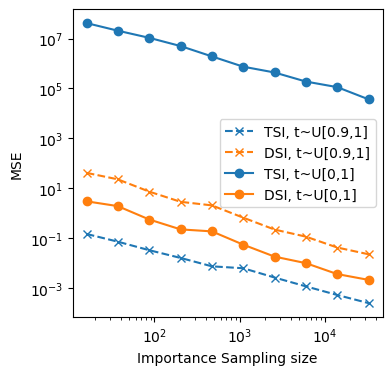

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(imp_sizes, errors_tsi, 'C0--x', label=f'TSI, t~U[{tmin:.1f},1]')
plt.plot(imp_sizes, errors_dsi, 'C1--x', label=f'DSI, t~U[{tmin:.1f},1]')
plt.plot(imp_sizes, errors_tsi2, 'C0-o', label='TSI, t~U[0,1]')
plt.plot(imp_sizes, errors_dsi2, 'C1-o', label='DSI, t~U[0,1]')
# plt.plot(imp_sizes, errors_comb, 'C3--x', label=f'DSI+TSI, t~U[{tmin:.1f},1]')
# plt.plot(imp_sizes, errors_comb2, 'C3-o', label='DSI+TSI, t~U[0,1]')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('Importance Sampling size')
plt.ylabel('MSE')
plt.legend();